## 1. Librerías y configuración incial

In [2]:
import pandas as pd             # manipulación de datos
import numpy as np              # manipulación de datos
import matplotlib.pyplot as plt # visualización
import seaborn as sns           # visualización

#!pip install rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
%load_ext rpy2.ipython
base = importr('base')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 2. Datos

In [4]:
%%R -o CASchools 
library(AER)
data(CASchools)

# 3. Modelo

In [5]:
CASchools.head(2)

,district,school,county,grades,students,teachers,calworks,lunch,computer,expenditure,income,english,read,math
1,75119,Sunol Glen Unified,1,2,195.0,10.90,0.5102,2.040800,67.0,6384.911133,22.690001,0.000000,691.599976,690.000000
2,61499,Manzanita Elementary,2,2,240.0,11.15,15.4167,47.916698,101.0,5099.380859,9.824000,4.583333,660.500000,661.900024


In [81]:
#CASchools.describe(include='all').transpose()

In [6]:
df = (CASchools 
    .assign(tamaño = lambda x: x['students']/x['teachers'])
    
    [['math','tamaño','expenditure','county','students','lunch','teachers','calworks','income','english']]

    .copy()
)

df.head(2)

,math,tamaño,expenditure,county,students,lunch,teachers,calworks,income,english
1,690.000000,17.889909,6384.911133,1,195.0,2.040800,10.90,0.5102,22.690001,0.000000
2,661.900024,21.524664,5099.380859,2,240.0,47.916698,11.15,15.4167,9.824000,4.583333


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

X = df.drop('math',axis=1).copy()
y = df['math']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pipe = Pipeline([
  ('imputador',      SimpleImputer(strategy='constant', fill_value= 0)),
  ('scaler',         StandardScaler()), 
  ('random_forest',  RandomForestRegressor(n_estimators=100, random_state=42))
])
  
pipe.fit(X_train, y_train)
modelo = pipe['random_forest']

In [8]:
importancia = pd.DataFrame({'variable':X_train.columns,
              'importancia':modelo.feature_importances_})

importancia.sort_values('importancia',ascending=False)

,variable,importancia
4,lunch,0.669572
7,income,0.102139
6,calworks,0.058608
0,tamaño,0.032455
8,english,0.030558
1,expenditure,0.030240
2,county,0.026429
3,students,0.026116
5,teachers,0.023882


Predicciones en test

In [9]:
preds_test = pd.DataFrame({'math':y_test, 
              'math_pred':pipe.predict(X_test)})

preds_test.head(2)

,math,math_pred
146,643.400024,640.752996
335,674.099976,652.215995


# 4. Visualización de resultados

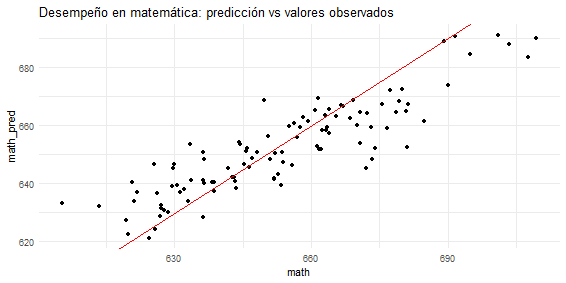

In [11]:
%%R -i preds_test -w 20 -h 10 --units cm

library(tidyverse)

preds_test %>% 
  ggplot(aes(x=math, y=math_pred))+
  geom_point()+
  geom_abline(intercept=0, slope=1, color='red')+
  labs(title = "Desempeño en matemática: predicción vs valores observados")+
  theme_minimal()



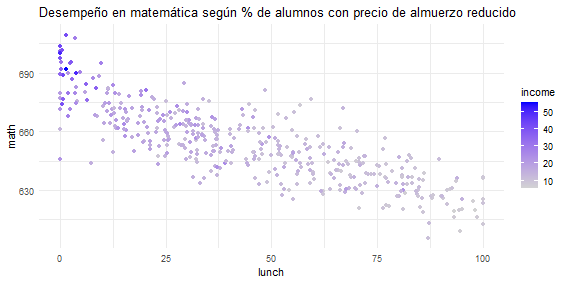

In [12]:
%%R -w 20 -h 10 --units cm

library(tidyverse)

CASchools %>% 
  ggplot(aes(x=lunch, y=math, color=income))+
  geom_point()+
  scale_color_gradient(low='lightgrey',  high='blue')+
  labs(title = "Desempeño en matemática según % de alumnos con precio de almuerzo reducido")+
  theme_minimal()